# ECBM E4040 - Assignment 1, Task 3: Dimensionality Reduction

This task is devoted to dimensionality reduction. How to map high-dimensional data into low-dimensional space is an interesting topic in the machine learning field. It is related to another hot topic -- unsupervised learning. In this section, you are going to learn two different methods for this dimensionality reduction.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

## Load Data

We will use the CIFAR-10 dataset.

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)

<span style="color:red"><strong>TODO</strong></span>: You have to complete the code in **./ecbm4040/features/pca.py**.

### Naive PCA

In [3]:
from ecbm4040.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))

In [4]:
# Start PCA
K = 500
P, T = pca_naive(X_patch, K)

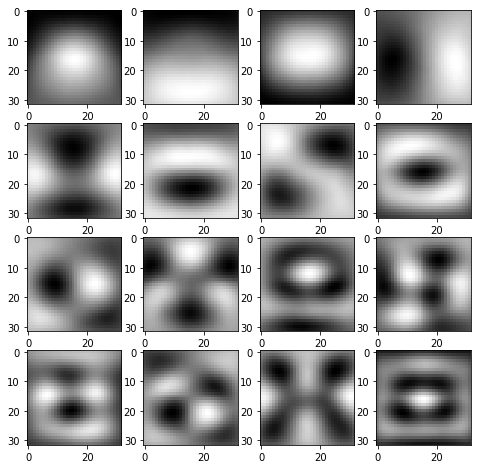

In [5]:
# TODO: Show principle components of P using a 4x4 subplot
# Visualize P
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

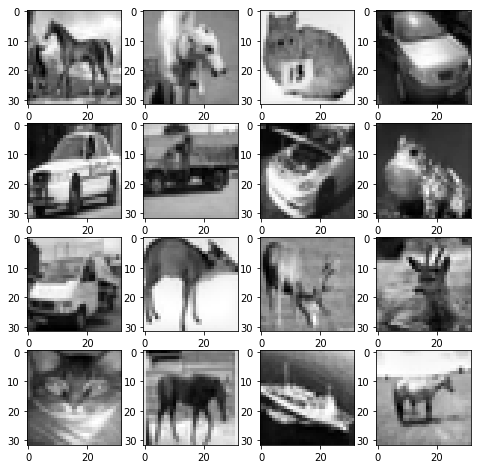

In [6]:
# Select a small set of images for test
num_training = 50000
num_pca = 16
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

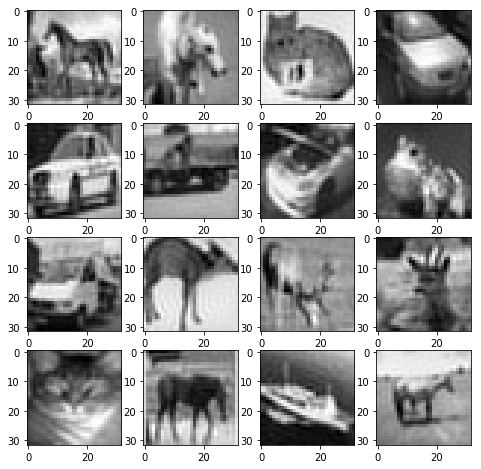

In [7]:
# TODO: Test your result
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

<span style="color:red"><strong>TODO</strong></span>: Use PCA to preprocess images before training a neural network: 

1. Do PCA preprocessing on each channel of the original image separately.
2. Stack PCA features from three channels into one vector, and use that vector as an input for MLP.
3. Train the MLP and show the results. 

In [14]:
from ecbm4040.train_funcs import train, test
from ecbm4040.classifiers.mlp import MLP

In [9]:
def preprocessing_pca(X,K):
    X_patch_1 = X[:,:,:,0]
    X_patch_2 = X[:,:,:,1]
    X_patch_3 = X[:,:,:,2]

    X_patch_1 = np.reshape(X_patch_1, (X_patch_1.shape[0], -1))
    X_patch_2 = np.reshape(X_patch_2, (X_patch_2.shape[0], -1))
    X_patch_3 = np.reshape(X_patch_3, (X_patch_3.shape[0], -1))

    # Start PCA
    K = 200
    P1, T1 = pca_naive(X_patch_1, K)
    P2, T2 = pca_naive(X_patch_2, K)
    P3, T3 = pca_naive(X_patch_3, K)
    
    X_patch = np.hstack((np.dot(X_patch_1,P1.T),np.dot(X_patch_2,P2.T),np.dot(X_patch_3,P3.T)))
    return(X_patch,P1,P2,P3)

In [10]:
X_patch_train,P1,P2,P3 = preprocessing_pca(X_train,K)

X_patch_1 = X_test[:,:,:,0]
X_patch_2 = X_test[:,:,:,1]
X_patch_3 = X_test[:,:,:,2]

X_patch_1 = np.reshape(X_patch_1, (X_patch_1.shape[0], -1))
X_patch_2 = np.reshape(X_patch_2, (X_patch_2.shape[0], -1))
X_patch_3 = np.reshape(X_patch_3, (X_patch_3.shape[0], -1))

X_patch_test = np.hstack((np.dot(X_patch_1,P1.T),np.dot(X_patch_2,P2.T),np.dot(X_patch_3,P3.T)))

X_patch_val = X_patch_train[-num_validation:]

<span style="color:red"><strong>TODO</strong></span>: Plot training, validation and test set accuracy.

In [15]:
model = MLP(input_dim=600, hidden_dims=[100,50], num_classes=10, reg=0.1, weight_scale=1e-2)

num_epoch = 30
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_patch_train, y_train, X_patch_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_patch_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.10423, new learning rate = 0.00095
epoch 2: valid acc = 0.099992, new learning rate = 0.0009025
epoch 3: valid acc = 0.100002, new learning rate = 0.000857375
epoch 4: valid acc = 0.099601, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.101832, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.100629, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.100403, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.100513, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.10014, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.100365, new learning rate = 0.0005987369392383785
epoch 11: valid acc = 0.100968, new learning rate = 0.0005688000922764595
epoch 12: valid acc = 0.101979, new learning rate = 0.0005403600876626365
epoch 13: valid acc = 0.101216, new learning rate = 0.0005133420832795047
epoch 14: valid acc = 0.100406, new learning rate 

0.1

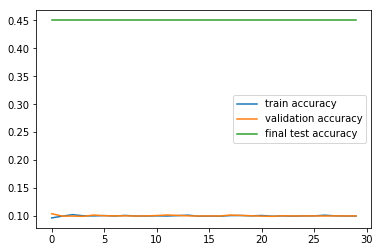

In [16]:
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.plot(range(30),[0.45]*30,label='final test accuracy')
plt.legend()
plt.show()

## Part 2: t-SNE (not graded)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [ ]:
from ecbm4040.features.tsne import tsne

#### tSNE of original data

In [ ]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

In [ ]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, the tSNE of data after two-layer networks is shown as multiple clusters in a 2D panel.

In [ ]:
# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

In [ ]:
# run tSNE
X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 10)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

In [ ]:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()